### Initialize notebook

In [161]:
BASE_PROJECT_DIR = '/home/akhanal1/ature'
BASE_PROJECT_DIR = '/home/ak/PycharmProjects/ature'

import os
import sys
import traceback

sys.path.append(BASE_PROJECT_DIR)
os.chdir(BASE_PROJECT_DIR)

import torch
import torch.optim as optim
from neuralnet.unet.model import UNet
from neuralnet.unet.unet_dataloader import PatchesGenerator
from neuralnet.unet.unet_trainer import UNetNNTrainer
import torchvision.transforms as transforms
import auto_split as asp
from neuralnet.unet.runs import DRIVE as uDRIVE
from neuralnet.thrnet.runs import DRIVE as pDRIVE

RUNS = [DRIVE]

In [162]:
from PIL import Image as IMG
import numpy as np
import utils.img_utils as iu
from commons.IMAGE import Image
import json

In [163]:
image = Image()
imap = Image()

In [167]:
image.load_file(uDRIVE['Dirs']['image'],  '19_test.tif')
image.working_arr=image.image_arr[:,:,1]

In [168]:
imap.load_file(pDRIVE['Dirs']['image'],  '19_test.png')
imap.working_arr = imap.image_arr
imap.load_ground_truth(pDRIVE['Dirs']['truth'], pDRIVE['Funcs']['truth_getter'])

In [171]:
iseg = imap.working_arr.copy()
iseg[iseg>=170]=255
iseg[iseg<170]=0

In [172]:
rgb = iu.get_rgb_scores(iseg, imap.ground_truth)
iu.get_praf1(iseg, imap.ground_truth)

{'Accuracy': 0.9792399078676203,
 'F1': 0.8739650413983441,
 'Precision': 0.8803143185440527,
 'Recall': 0.8677066968689489}

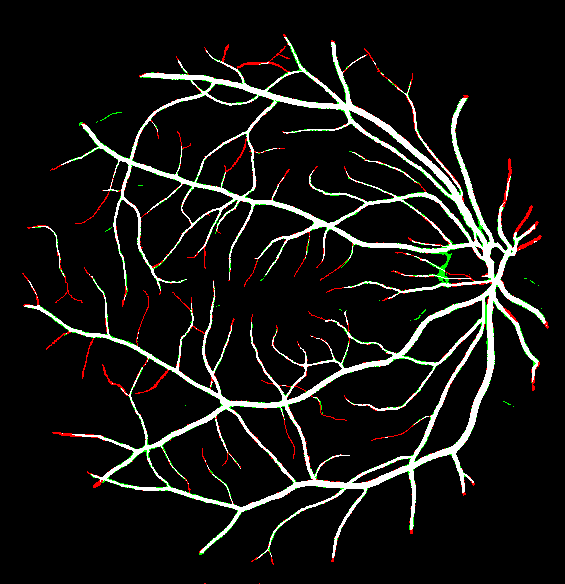

In [173]:
IMG.fromarray(rgb)

### Load train data

In [136]:
files = os.listdir(uDRIVE['Dirs']['image'])

In [26]:
j = np.array(j*255, dtype=np.uint8).squeeze()

In [140]:
train = []
test = []
for f in files:
    if 'train' in f:
        train.append(f)
    else:
        test.append(f)

In [146]:
test1 = test[0:10]
val = test[10:20]

In [151]:
conf = {'train':train, 'validation':val, 'test':test1}

In [155]:
file = open('runconf.txt', 'w')
file.write(json.dumps(conf))
file.flush()
file.close()

In [159]:
test == test1+val

True

In [ ]:
03_test.tif PRF1A:  [0.83, 0.718, 0.77, 0.956]
07_test.tif PRF1A:  [0.852, 0.71, 0.775, 0.956]
09_test.tif PRF1A:  [0.857, 0.698, 0.77, 0.957]
12_test.tif PRF1A:  [0.852, 0.709, 0.774, 0.958]
16_test.tif PRF1A:  [0.853, 0.724, 0.784, 0.959]
05_test.tif PRF1A:  [0.86, 0.716, 0.781, 0.958]
10_test.tif PRF1A:  [0.857, 0.719, 0.782, 0.958]
17_test.tif PRF1A:  [0.859, 0.718, 0.782, 0.958]
13_test.tif PRF1A:  [0.861, 0.719, 0.784, 0.958]
Score imp

### Load Validation Data